# Setup

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
from pathlib import Path
import numpy as np
from datetime import datetime

setup matplotlib for LaTeX

In [2]:
import matplotlib
matplotlib.rc('font', size=10)

In [3]:
# import matplotlib
# matplotlib.use("pgf")
# matplotlib.rcParams.update({
#     "pgf.texsystem": "pdflatex",
#     'font.family': 'serif',
#     'text.usetex': True,
#     'pgf.rcfonts': False,
# })

# import os
# os.environ["PATH"] += ';C:\\Users\\papse\\AppData\\Local\\Programs\\MiKTeX\\miktex\\bin\\x64'

In [4]:
gss_table = pd.read_stata(Path('./data/gss_data.dta'))
video_table = pd.read_parquet(Path('./data/video_data.parquet'))
traffic_table = pd.read_parquet(Path('./data/traffic_data.parquet'))
category_table = pd.read_parquet(Path('./data/category_data.parquet'))
population_table = pd.read_parquet(Path('./data/population_data.parquet'))

# Condom and porn

In [5]:
data_to_viz_condom = (
    gss_table
#     .assign(year = lambda df: df['year'].apply(lambda x: datetime(x, 1,1)))
    .groupby(["year", "sex", "condom"])
    .agg(count=("id", "count"))
    .pipe(
        lambda df: df.reset_index()
        .set_index(["year", "sex"])
        .join(df.reset_index().groupby(["year", "sex"]).agg(total=("count", "sum")))
    )
    .assign(ratio=lambda df: df["count"] / df["total"])
    .set_index('condom', append=True)
    ['ratio']
)

In [6]:
data_to_viz_porn = (
    video_table.groupby("date_m")
    .first()
    .index.to_series()
    .apply(
        lambda date: (
            video_table[lambda df: df["date_m"] <= date]["view_per_traffic"]
            * traffic_table[lambda df: df.index.to_series() == date][
                "traffic_usa"
            ].sum()
        ).sum()
    )
    .to_frame()
    .assign(
        year=lambda df: df.index.to_series().dt.year,
        month=lambda df: df.index.to_series().dt.month,
    )
    .pipe(lambda df: pd.merge(df, population_table, on=["year", "month"]))
    .groupby("year")
    .agg(views=("date_m", "sum"), population=("population", "mean"))
    .assign(views_pop=lambda df: df["views"] / df["population"])["views_pop"]
)

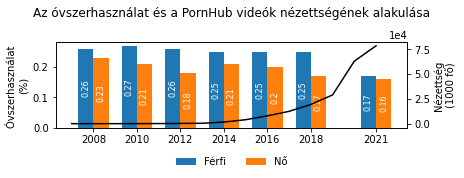

In [7]:
labels = data_to_viz_condom[slice(None), "male", "used last time"].index
men_means = data_to_viz_condom[slice(None), "male", "used last time"].values.round(2)
women_means = data_to_viz_condom[slice(None), "female", "used last time"].values.round(
    2
)

x = labels  # the label locations
width = 0.7  # the width of the bars

fig, axes = plt.subplots()
fig.set_size_inches(w=6.30045, h=6.30045 / 4)
rects1 = axes.bar(x - width / 2, men_means, width, label="Férfi")
rects2 = axes.bar(x + width / 2, women_means, width, label="Nő")

axes.set_xticks(x)

axes_2 = axes.twinx()
axes_2.plot(
    data_to_viz_porn.index, data_to_viz_porn, label="Összes nézettség", color="black"
)

axes.legend(
    bbox_to_anchor=(0, -0.5, 1, 0.2),
    loc="center",
    ncol=2,
    framealpha=0,
    borderaxespad=0,
)

axes_2.ticklabel_format(style="sci", axis="y", scilimits=(0, 0))

axes.bar_label(
    rects1,
    padding=0,
    fontsize=8,
    label_type="center",
    color="white",
    rotation=90,
#     fmt="%.2f%%",
)
axes.bar_label(
    rects2,
    padding=0,
    fontsize=8,
    label_type="center",
    color="white",
    rotation=90,
#     fmt="%.2f%%",
)

axes.set_ylabel("Óvszerhasználat \n(%)")
axes_2.set_ylabel("Nézettség \n(1000 fő)")

axes.set_title('Az óvszerhasználat és a PornHub videók nézettségének alakulása', pad = 25)

plt.show()

In [8]:
fig.savefig(Path("./figures/condom_view.png"), bbox_inches="tight", dpi=1200)

In [9]:
data_to_viz_porn_amateur = (
    video_table.join(category_table)[
        lambda df: df["category"].isin(["Amateur", "Verified Amateurs"])
    ]
    .groupby(level=0)
    .first()
    .pipe(
        lambda table: table.groupby("date_m")
        .first()
        .index.to_series()
        .apply(
            lambda date: (
                table[lambda df: df["date_m"] <= date]["view_per_traffic"]
                * traffic_table[lambda df: df.index.to_series() == date][
                    "traffic_usa"
                ].sum()
            ).sum()
        )
        .to_frame()
        .assign(
            year=lambda df: df.index.to_series().dt.year,
            month=lambda df: df.index.to_series().dt.month,
        )
        .pipe(lambda df: pd.merge(df, population_table, on=["year", "month"]))
        .groupby("year")
        .agg(views=("date_m", "sum"), population=("population", "mean"))
        .assign(views_pop=lambda df: df["views"] / df["population"])["views_pop"]
    )
)

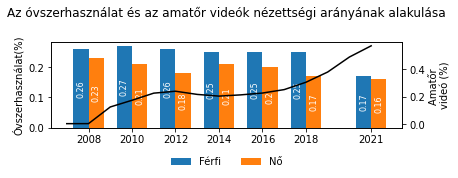

In [10]:
labels = data_to_viz_condom[slice(None), "male", "used last time"].index
men_means = data_to_viz_condom[slice(None), "male", "used last time"].values.round(2)
women_means = data_to_viz_condom[slice(None), "female", "used last time"].values.round(
    2
)

x = labels  # the label locations
width = 0.7  # the width of the bars

fig, axes = plt.subplots()
rects1 = axes.bar(x - width / 2, men_means, width, label="Férfi")
rects2 = axes.bar(x + width / 2, women_means, width, label="Nő")

axes.set_xticks(x)

axes_2 = axes.twinx()
axes_2.plot(
    (data_to_viz_porn_amateur / data_to_viz_porn).index,
    (data_to_viz_porn_amateur / data_to_viz_porn),
    label="Amatőr arány",
    color="black",
)

fig.set_size_inches(w=6.30045, h=6.30045 / 4)

axes.legend(
    bbox_to_anchor=(0, -0.5, 1, 0.2),
    loc="center",
    ncol=2,
    framealpha=0,
    borderaxespad=0,
    
)

axes.bar_label(
    rects1,
    padding=0,
    fontsize=8,
    label_type="center",
    color="white",
    rotation=90,
#     fmt="%.2f%%",
)
axes.bar_label(
    rects2,
    padding=0,
    fontsize=8,
    label_type="center",
    color="white",
    rotation=90,
#     fmt="%.2f%%",
)

axes.set_ylabel("Óvszerhasználat(%)")
axes_2.set_ylabel("Amatőr \nvideó (%)")

axes.set_title('Az óvszerhasználat és az amatőr videók nézettségi arányának alakulása', pad = 25)

plt.show()

In [11]:
fig.savefig(Path('./figures/condom_amateur.png'), bbox_inches='tight', dpi = 1200)

# Harrastment and porn

In [12]:
data_to_viz_harrastment = (
    gss_table
#     .assign(year = lambda df: df['year'].apply(lambda x: datetime(x, 1,1)))
    .groupby(["year", "sex", "wkharsex"])
    .agg(count=("id", "count"))
    .pipe(
        lambda df: df.reset_index()
        .set_index(["year", "sex"])
        .join(df.reset_index().groupby(["year", "sex"]).agg(total=("count", "sum")))
    )
    .assign(ratio=lambda df: df["count"] / df["total"])
    .set_index('wkharsex', append=True)
    ['ratio']
    [lambda x: ~x.isna()]
)

In [13]:
data_to_viz_porn_hardcore = (
    video_table.join(category_table)[lambda df: df["category"] == "Hardcore"]
    .groupby(level=0)
    .first()
    .pipe(
        lambda table: table.groupby("date_m")
        .first()
        .index.to_series()
        .apply(
            lambda date: (
                table[lambda df: df["date_m"] <= date]["view_per_traffic"]
                * traffic_table[lambda df: df.index.to_series() == date][
                    "traffic_usa"
                ].sum()
            ).sum()
        )
        .to_frame()
        .assign(
            year=lambda df: df.index.to_series().dt.year,
            month=lambda df: df.index.to_series().dt.month,
        )
        .pipe(lambda df: pd.merge(df, population_table, on=["year", "month"]))
        .groupby("year")
        .agg(views=("date_m", "sum"), population=("population", "mean"))
        .assign(views_pop=lambda df: df["views"] / df["population"])["views_pop"]
    )
)

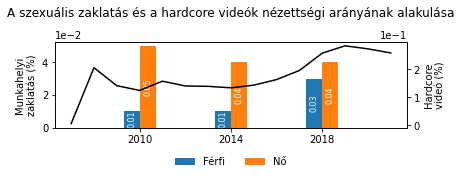

In [14]:
labels = data_to_viz_harrastment[slice(None), 'male', 'yes'].index
men_means = data_to_viz_harrastment[slice(None), 'male', 'yes'].values.round(2)
women_means = data_to_viz_harrastment[slice(None), 'female', 'yes'].values.round(2)

x = labels  # the label locations
width = 0.7  # the width of the bars

fig, axes = plt.subplots(figsize=[16, 4])
rects1 = axes.bar(x - width / 2, men_means, width, label="Férfi")
rects2 = axes.bar(x + width / 2, women_means, width, label="Nő")

axes.set_xticks(x)

axes_2 = axes.twinx()
axes_2.plot((data_to_viz_porn_hardcore / data_to_viz_porn).index, (data_to_viz_porn_hardcore / data_to_viz_porn), label = 'Hardcore arány', color = 'black')

fig.set_size_inches(w=6.30045, h=6.30045 / 4)

axes.legend(
    bbox_to_anchor=(0, -0.5, 1, 0.2),
    loc="center",
    ncol=2,
    framealpha=0,
    borderaxespad=0,
    
)

axes.ticklabel_format(style="sci", axis="y", scilimits=(0, 0))
axes_2.ticklabel_format(style="sci", axis="y", scilimits=(0, 0))

axes.bar_label(
    rects1,
    padding=0,
    fontsize=8,
    label_type="center",
    color="white",
    rotation=90,
#     fmt="%.2f%%",
)
axes.bar_label(
    rects2,
    padding=0,
    fontsize=8,
    label_type="center",
    color="white",
    rotation=90,
#     fmt="%.2f%%",
)

axes.set_ylabel("Munkahelyi \nzaklatás (%)")
axes_2.set_ylabel("Hardcore\nvideó (%)")

axes.set_title('A szexuális zaklatás és a hardcore videók nézettségi arányának alakulása', pad = 25)

plt.show()

In [15]:
fig.savefig(Path('./figures/harrasment_hardcore.png'), bbox_inches='tight', dpi = 1200)

# Homosexuality and porn

In [16]:
data_to_viz_homosex = (
    gss_table
#     .assign(year = lambda df: df['year'].apply(lambda x: datetime(x, 1,1)))
    .groupby(["year", "sex", "sexornt"])
    .agg(count=("id", "count"))
    .pipe(
        lambda df: df.reset_index()
        .set_index(["year", "sex"])
        .join(df.reset_index().groupby(["year", "sex"]).agg(total=("count", "sum")))
    )
    .assign(ratio=lambda df: df["count"] / df["total"])
    .set_index('sexornt', append=True)
    ['ratio']
    [lambda x: ~x.isna()]
)

In [17]:
data_to_viz_porn_homosex = (
    video_table.join(category_table)[lambda df: df["category"].isin(["Lesbian", "Gay"])]
    .groupby(level=0)
    .first()
    .pipe(
        lambda table: table.groupby("date_m")
        .first()
        .index.to_series()
        .apply(
            lambda date: (
                table[lambda df: df["date_m"] <= date]["view_per_traffic"]
                * traffic_table[lambda df: df.index.to_series() == date][
                    "traffic_usa"
                ].sum()
            ).sum()
        )
        .to_frame()
        .assign(
            year=lambda df: df.index.to_series().dt.year,
            month=lambda df: df.index.to_series().dt.month,
        )
        .pipe(lambda df: pd.merge(df, population_table, on=["year", "month"]))
        .groupby("year")
        .agg(views=("date_m", "sum"), population=("population", "mean"))
        .assign(views_pop=lambda df: df["views"] / df["population"])["views_pop"]
    )
)

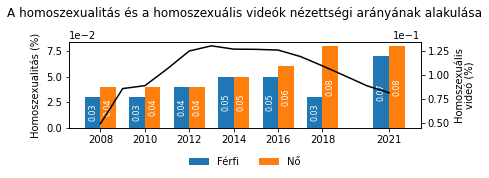

In [18]:
labels = data_to_viz_homosex.loc[pd.IndexSlice[:, 'male', 'gay, lesbian, or homosexual']].index
men_means = data_to_viz_homosex.loc[pd.IndexSlice[:, 'male', ['gay, lesbian, or homosexual', 'bisexual']]].groupby(['year', 'sex']).sum().values.round(2)
women_means = data_to_viz_homosex.loc[pd.IndexSlice[:, 'female', ['gay, lesbian, or homosexual', 'bisexual']]].groupby(['year', 'sex']).sum().values.round(2)

x = labels  # the label locations
width = 0.7  # the width of the bars

fig, axes = plt.subplots(figsize=[16, 4])
rects1 = axes.bar(x - width / 2, men_means, width, label="Férfi")
rects2 = axes.bar(x + width / 2, women_means, width, label="Nő")

axes.set_xticks(x)

axes_2 = axes.twinx()
axes_2.plot((data_to_viz_porn_homosex / data_to_viz_porn).index, (data_to_viz_porn_homosex / data_to_viz_porn), label = 'Homoszexuális arány', color = 'black')


fig.set_size_inches(w=6.30045, h=6.30045 / 4)

axes.legend(
    bbox_to_anchor=(0, -0.5, 1, 0.2),
    loc="center",
    ncol=2,
    framealpha=0,
    borderaxespad=0,
    
)


axes.ticklabel_format(style="sci", axis="y", scilimits=(0, 0))
axes_2.ticklabel_format(style="sci", axis="y", scilimits=(0, 0))


axes.bar_label(
    rects1,
    padding=0,
    fontsize=8,
    label_type="center",
    color="white",
    rotation=90,
#     fmt="%.2f%%",
)
axes.bar_label(
    rects2,
    padding=0,
    fontsize=8,
    label_type="center",
    color="white",
    rotation=90,
#     fmt="%.2f%%",
)

axes.set_ylabel("Homoszexualitás (%)")
axes_2.set_ylabel("Homoszexuális\nvideó (%)")

axes.set_title('A homoszexualitás és a homoszexuális videók nézettségi arányának alakulása', pad = 25)

plt.show()

In [19]:
fig.savefig(Path('./figures/homosexuality_homosexual.png'), bbox_inches='tight', dpi = 1200)